# MDG1 - Eradicate Extreme Poverty And Hunger 

#### In order to begin our analysis let's review how wealth has grown around the years among the different countries. 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

In [88]:
country_metadata = pd.read_csv('data\\GDP_BY_COUNTRY\\Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv')
country_metadata.drop(['IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5'], axis=1, inplace=True)

# Loading historical GDP by country data from World Bank Data(data.worldbank.org)
historical_gdp_by_country = pd.read_csv('data\\GDP_BY_COUNTRY\\API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv', header=2)
historical_gdp_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_gdp_by_country = pd.merge(historical_gdp_by_country, country_metadata, how='left', on=['Country Code'])
historical_gdp_by_country = historical_gdp_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='GDP(US$)')

historical_gdp_by_country['GDP(US$)'] = historical_gdp_by_country['GDP(US$)'].apply(lambda x : x/10**9)
historical_gdp_by_country.rename(columns={'GDP(US$)': 'GDP(US$ in Billions)'}, inplace=True)

# Loading historical Population by country data from World Bank(data.worldbank.org)
historical_pop_by_country = pd.read_csv('data\\POP_BY_COUNTRY\\API_SP.POP.TOTL_DS2_en_csv_v2_10515200.csv', header=2)
historical_pop_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_pop_by_country = pd.merge(historical_pop_by_country, country_metadata, how='left', on=['Country Code'])
historical_pop_by_country = historical_pop_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='Pop(in millions)')

historical_pop_by_country = historical_pop_by_country[(historical_pop_by_country['Pop(in millions)'] != 'SP.POP.TOTL') & (historical_pop_by_country['Pop(in millions)'] != 'Population, total')]
historical_pop_by_country['Pop(in millions)'].astype(np.float64, copy=False)
historical_pop_by_country['Pop(in millions)'] = historical_pop_by_country['Pop(in millions)'].apply(lambda x : x/10**6)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [89]:
historical_gdp_by_region = historical_gdp_by_country.groupby(by=['Region','Year'], as_index=False).agg({'GDP(US$ in Billions)': 'sum'})
historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['GDP(US$ in Billions)'] > 0]

historical_pop_by_region = historical_pop_by_country.groupby(by=['Region', 'Year'], as_index=False).agg({'Pop(in millions)': 'sum'})
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Pop(in millions)'] > 0]

historical_gdp_per_capita_by_region = historical_gdp_by_region[['Region', 'Year']]
historical_gdp_per_capita_by_region['GDP Per Capita (per US$1.000,00)'] = historical_gdp_by_region['GDP(US$ in Billions)']*(10**3)/historical_pop_by_region['Pop(in millions)']

historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['Year'] > '1980']
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Year'] > '1980']
historical_gdp_per_capita_by_region = historical_gdp_per_capita_by_region[historical_gdp_per_capita_by_region['Year'] > '1980']


## Brief Economical Evaluation - GDP, Population and GDP per capita

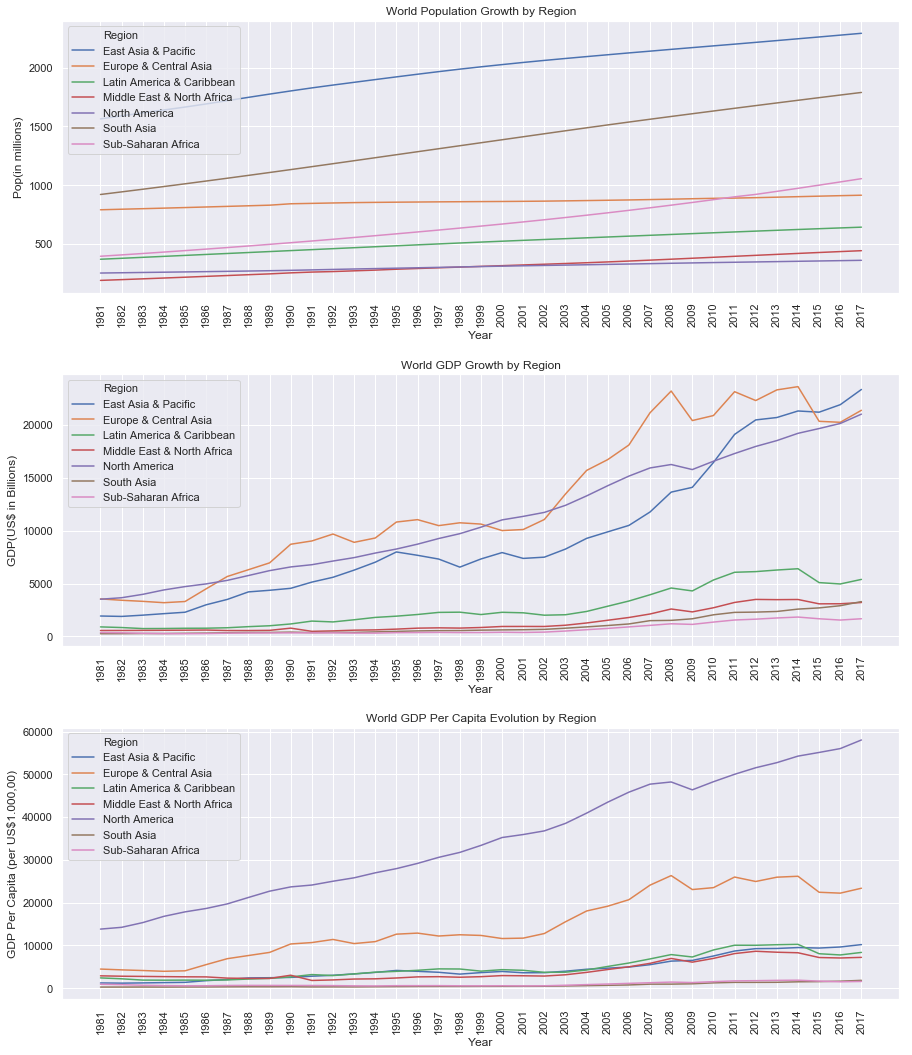

In [90]:
fig,ax = plt.subplots(nrows=3, figsize=(15,18))
titles = ['World Population Growth by Region', 'World GDP Growth by Region', 'World GDP Per Capita Evolution by Region']
for i in range(3):
    plt.sca(ax[i])
    plt.title(titles[i])
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.3)

sns.lineplot(x='Year', y='Pop(in millions)', hue='Region', data=historical_pop_by_region, ax=ax[0])
sns.lineplot(x='Year', y='GDP(US$ in Billions)', hue='Region', data=historical_gdp_by_region, ax=ax[1])
sns.lineplot(x='Year', y='GDP Per Capita (per US$1.000,00)', hue='Region', data=historical_gdp_per_capita_by_region, ax=ax[2])

## Analyzing Extreme Poverty Distribution around the Globe

In [91]:
def createWBDataFrame(path):
    df = pd.read_csv(path, header=2)
    df = pd.merge(df, country_metadata, how='left', on=['Country Code'])
    return df.drop(['Indicator Name', 'Unnamed: 63'], axis=1)

def tideWBDataFrame(df):
    df = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Region', 'Indicator Code'], var_name='Year', value_name='observation')
    df = pd.pivot_table(df, columns=['Indicator Code'], index=['Country Name', 'Country Code', 'Region', 'Year'], values='observation', aggfunc=np.mean)
    return df.reset_index()

def keepMetrics(df, metrics):
    standard_columns = ['Country Name', 'Country Code', 'Region', 'Year']
    return df.loc[:, standard_columns + metrics]

In [92]:
extreme_poverty_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Environment\\API_19_DS2_en_csv_v2_10515758.csv')
extreme_poverty_by_country = tideWBDataFrame(extreme_poverty_by_country)

# Limiting data for the last 30 years
extreme_poverty_by_country = extreme_poverty_by_country[extreme_poverty_by_country['Year'] > '1980']
extreme_poverty_by_country = keepMetrics(extreme_poverty_by_country, ['SI.POV.DDAY','SP.POP.TOTL'])

# Renaming observation columns
extreme_poverty_by_country.rename(columns={'SI.POV.DDAY': 'Extreme Poverty(% pop)','SP.POP.TOTL': 'Total Pop.'}, inplace=True)

### 1.0 - Extreme Poverty Distribution

In [93]:
# Manipulating data to bring a better understanding of the situation.
extreme_poverty_by_country['last_obs_year'] = np.nan
extreme_poverty_by_country['last_obs_year'] = extreme_poverty_by_country[extreme_poverty_by_country['Extreme Poverty(% pop)'].notnull()]['Year']
extreme_poverty_by_country.sort_values(['Country Code', 'Year'], inplace=True)

aux = pd.DataFrame(columns=extreme_poverty_by_country.columns)
for code in extreme_poverty_by_country['Country Code'].unique():
    aux = pd.concat([aux, extreme_poverty_by_country[extreme_poverty_by_country['Country Code'] == code].fillna(method='ffill')])
extreme_poverty_by_country = aux

extreme_poverty_by_country['Total Pop. in Extreme Poverty'] = extreme_poverty_by_country['Total Pop.']*extreme_poverty_by_country['Extreme Poverty(% pop)']/100
extreme_poverty_by_country['text'] = ["{one}<br>Extreme Poverty: {two} % <br>Extreme Poverty: {three} millions<br>Last obtained: {four}".format(one=row['Country Name'], two=row['Extreme Poverty(% pop)'], three=np.round(row['Total Pop. in Extreme Poverty']/10**6, 3), four=row['last_obs_year']) for index, row in extreme_poverty_by_country.iterrows()]     

### First Visualization

In [162]:
data_slider = []
for year in extreme_poverty_by_country['Year'].unique():
    extreme_poverty_year = extreme_poverty_by_country[extreme_poverty_by_country['Year'] == year]
    
    data = go.Choropleth(
                locationmode='ISO-3',
                locations=extreme_poverty_year['Country Code'],
                text=extreme_poverty_year['text'],
                z=extreme_poverty_year['Extreme Poverty(% pop)'],
                colorbar={'title':'Extreme Poverty (% of Population)','ticksuffix': '%'} 
        )
    data_slider.append(data)

steps = []
for i in range(len(data_slider)):
    correct_value = [False] * len(data_slider)
    correct_value[i] = True
    
    step = go.layout.slider.Step(
        method='restyle',
        args=['visible', correct_value],
        label="{}".format(1981+i)
    )
    steps.append(step)

layout = go.Layout(
            title = go.layout.Title(
                text = 'Evolution of Extreme Poverty (From 1981 to 2017)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            ),
            sliders = [go.layout.Slider(
                steps = steps,
                active = 0,
                currentvalue = {"prefix": "Year: "},
                pad = {"t": 1}
            )]
        )
fig = go.Figure(data=data_slider, layout=layout)
iplot(fig)

### Second Visualization

In [104]:
extreme_poverty_by_region = extreme_poverty_by_country.loc[:, ['Region', 'Year', 'Total Pop. in Extreme Poverty', 'Total Pop.']]
extreme_poverty_by_region.dropna(inplace=True)

extreme_poverty_by_region = extreme_poverty_by_region.groupby(['Region', 'Year'], as_index=False).agg({'Total Pop. in Extreme Poverty': 'sum', 'Total Pop.': 'sum'})
extreme_poverty_by_region['Mean Pop. in Extreme Poverty'] = np.round(100*extreme_poverty_by_region['Total Pop. in Extreme Poverty']/extreme_poverty_by_region['Total Pop.'], 2)

extreme_poverty_by_region = extreme_poverty_by_region[extreme_poverty_by_region['Year'] >= '1990']
extreme_poverty_by_region.sort_values(by=['Year', 'Region'], inplace=True)

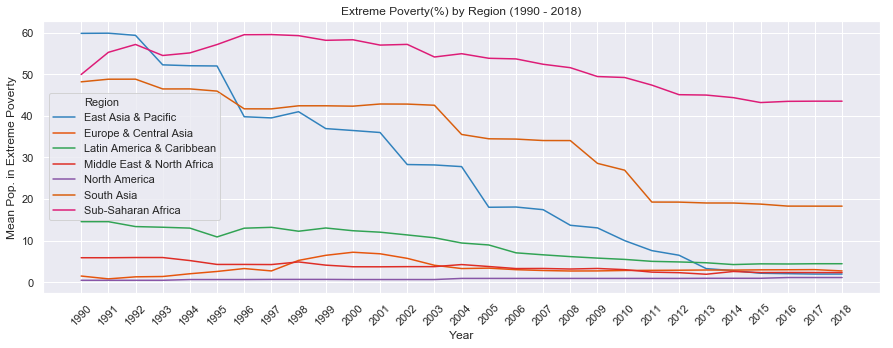

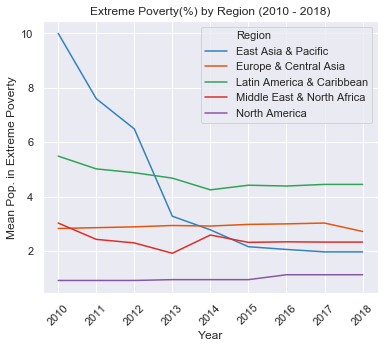

In [105]:
pal_1 = ['#3182bd', '#e6550d', '#31a354', '#de2d26', '#8856a7', '#d95f0e', '#dd1c77']
pal_2 = ['#3182bd', '#e6550d', '#31a354', '#de2d26', '#8856a7']
sns.set_palette(palette)
# Line chart grouping extreme poverty data by region

# This chart only takes into account the countries that have provided at least one data regarding Extreme Poverty in the timeframe presented(1981-2017).
# The data for Extreme Poverty considered by the chart is the last data provided by the country.
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.title('Extreme Poverty(%) by Region (1990 - 2018)')
sns.lineplot(x='Year', y='Mean Pop. in Extreme Poverty', hue='Region', data=extreme_poverty_by_region, palette=pal_1)

# Show another line chart to focus on the last years for East Asia, Latin America, North America, Middle East and Europe
plt.figure(figsize=(6, 5))
plt.xticks(rotation=45)
plt.title('Extreme Poverty(%) by Region (2010 - 2018)')
extreme_poverty_by_region_sub = extreme_poverty_by_region[(~extreme_poverty_by_region['Region'].isin(['South Asia', 'Sub-Saharan Africa'])) & (extreme_poverty_by_region['Year']>='2010')]
sns.lineplot(x='Year', y='Mean Pop. in Extreme Poverty', hue='Region', data=extreme_poverty_by_region_sub, palette=pal_2)

## Analyzing Deeper Socioeconomical, Healthy and Environmental Factors

#### Sub-Saharan Africa and South Asia are clearly the regions that need most assistance when it comes to eradicating poverty. 
#### Hence they along with Latin America will be the ones we look deeper to understand the driving factors that inhibit development on these countries.
#### In this section, we look at environmental, health, social and economical factors that might keep a nation from thriving economically. 

In [120]:
health_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Health\\API_8_DS2_en_csv_v2_10576655.csv')
health_by_country = tideWBDataFrame(health_by_country)
health_by_country = keepMetrics(health_by_country, ['SH.DYN.MORT', 'SH.DYN.AIDS.ZS', 'SH.TBS.INCD', 'SH.DTH.COMM.ZS', 'SN.ITK.DEFC.ZS', 'SP.DYN.TFRT.IN', 'SH.XPD.CHEX.GD.ZS'])
health_by_country.rename(columns={'SH.DYN.MORT': 'Mortality Rate Under 5(per 1.000 births)', 'SH.DYN.AIDS.ZS':'HIV - 15 to 49 (%)', 'SH.TBS.INCD': 'Inc. Tuberculosis(per 100.000)', 'SH.DTH.COMM.ZS': 'Death by Infectious Disease(5 of total)', 'SN.ITK.DEFC.ZS':'Undernourishment(% pop)', 'SP.DYN.TFRT.IN': 'Total Births per Women', 'SH.XPD.CHEX.GD.ZS': 'Expenditure on Health(% of GDP)'}, inplace=True)
health_by_country = health_by_country[health_by_country['Year'] > '1980']

underage_labour_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Labour\\API_10_DS2_en_csv_v2_10597117.csv')
underage_labour_by_country = tideWBDataFrame(underage_labour_by_country)
underage_labour_by_country = keepMetrics(underage_labour_by_country, ['SL.TLF.0714.ZS', 'SL.TLF.0714.WK.ZS', 'SL.TLF.0714.WK.TM', 'SL.UEM.NEET.ZS'])
underage_labour_by_country.rename(columns={'SL.TLF.0714.ZS': 'Children in employment 7-14 (% of children)', 'SL.TLF.0714.WK.ZS': 'Children in employment(Work only) - 7 to 14(% of chd in emp.)', 'SL.TLF.0714.WK.TM': 'Avg. Working Hours of work only children'}, inplace=True)
underage_labour_by_country = underage_labour_by_country[underage_labour_by_country['Year'] > '1980']

education_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Education\\API_4_DS2_en_csv_v2_10577018.csv')
education_by_country = tideWBDataFrame(education_by_country)
education_by_country = keepMetrics(education_by_country, ['SE.PRM.CMPT.ZS', 'SE.PRM.UNER.ZS', 'SE.PRM.ENRL.TC.ZS', 'SE.ADT.1524.LT.ZS', 'SE.XPD.TOTL.GD.ZS'])
education_by_country.rename(columns={'SE.PRM.CMPT.ZS': 'Primary Completion Rate (% of relevant age group)', 'SE.PRM.UNER.ZS': 'Children out of School(% primary school)',  'SE.PRM.ENRL.TC.ZS': 'Pupil Teacher ratio', 'SE.ADT.1524.LT.ZS': 'Youth Literacy Rate 15-24 (% pop)', 'SE.XPD.TOTL.GD.ZS': 'Expenditure on Education (% of GDP)'}, inplace=True)
education_by_country = education_by_country[education_by_country['Year'] > '1980']

economics_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Economics\\API_3_DS2_en_csv_v2_10577958.csv')
economics_by_country = tideWBDataFrame(economics_by_country)
economics_by_country = keepMetrics(economics_by_country, ['NY.GDP.PCAP.CD', 'NY.GDP.MKTP.KD.ZG', 'FP.CPI.TOTL.ZG', 'DT.ODA.ODAT.PC.ZS'])
economics_by_country.rename(columns={'NY.GDP.PCAP.CD': 'GDP per Capita(US$)', 'NY.GDP.MKTP.KD.ZG': 'GDP Growth(%)', 'FP.CPI.TOTL.ZG': 'Inflation Rate(%)', 'DT.ODA.ODAT.PC.ZS': 'ODA per capita(US$)'}, inplace=True)
economics_by_country = economics_by_country[economics_by_country['Year'] > '1980']

environment_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Environment\\API_19_DS2_en_csv_v2_10515758.csv')
environment_by_country = tideWBDataFrame(environment_by_country)
environment_by_country = keepMetrics(environment_by_country, ['AG.LND.PRCP.MM','EN.CLC.MDAT.ZS','AG.LND.ARBL.ZS','AG.LND.IRIG.AG.ZS','NV.AGR.TOTL.ZS','AG.YLD.CREL.KG', 'EG.ELC.ACCS.ZS'])
environment_by_country.rename(columns={'AG.LND.PRCP.MM': 'Avg precipitation(mm)','EN.CLC.MDAT.ZS': '% Pop affected by extreme conditions(Droughts, Flood, high temps)','AG.LND.ARBL.ZS': '% Arable Land','AG.LND.IRIG.AG.ZS': '% Agric. Irrigated Land','NV.AGR.TOTL.ZS': 'Agric., Florestry and Fishing(% of GDP)','AG.YLD.CREL.KG': 'Cereal Yield(Kg/hectare)','EG.ELC.ACCS.ZS': 'Access Electricity(% pop)'}, inplace=True)
environment_by_country = environment_by_country[environment_by_country['Year'] > '1980']

economics_by_country['text'] = ["{one}<br>GDP Growth: {two}% <br>GDP per capita: US${three} <br>Inflation Rate: {four}% <br>ODA per capita: US${five}".format(one=row['Country Name'], two=np.round(row['GDP Growth(%)'],2), three=np.round(row['GDP per Capita(US$)'],2), four=np.round(row['Inflation Rate(%)'],2), five=np.round(row['ODA per capita(US$)'],2)) for index, row in economics_by_country.iterrows()] 

### 1.3 - Principal Problems faced by different regions

#### Sub-Saharan Africa

In [121]:
economics_by_country_africa = economics_by_country[economics_by_country['Region'] == 'Sub-Saharan Africa']
underage_labour_by_country_africa = underage_labour_by_country[underage_labour_by_country['Region'] == 'Sub-Saharan Africa']
education_by_country_africa = education_by_country[education_by_country['Region'] == 'Sub-Saharan Africa']
environment_by_country_africa = environment_by_country[environment_by_country['Region'] == 'Sub-Saharan Africa']
health_by_country_africa = health_by_country[health_by_country['Region'] == 'Sub-Saharan Africa']


In [156]:
g_ed = education_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'Expenditure on Education (% of GDP)']]
g_health = health_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'Expenditure on Health(% of GDP)']]

g_ed_and_health = pd.merge(g_ed, g_health, on=['Year', 'Region', 'Country Code', 'Country Name'])
g_ed_and_health = g_ed_and_health.groupby(['Year', 'Region'], as_index=False).agg({'Expenditure on Education (% of GDP)':'mean', 'Expenditure on Health(% of GDP)': 'mean'})

g_ed_and_health = g_ed_and_health[g_ed_and_health['Year'] >= '2000']


In [158]:
g_ed_and_health['Region'].unique()

array(['East Asia & Pacific', 'Europe & Central Asia',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'North America', 'South Asia', 'Sub-Saharan Africa'], dtype=object)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

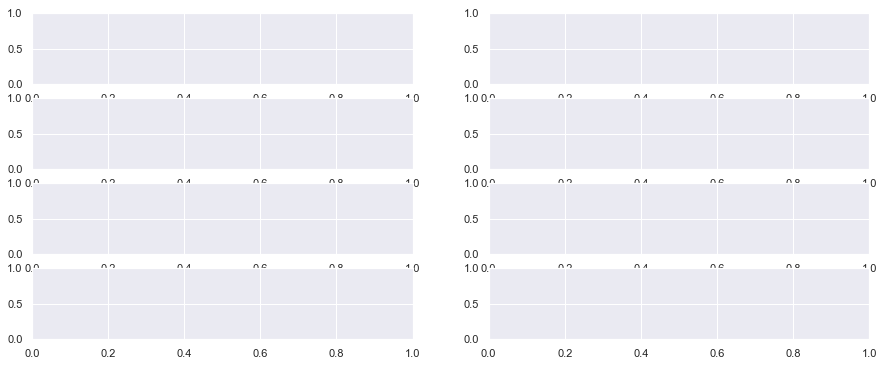

In [161]:
regions = g_ed_and_health['Region'].unique()

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(15,6))
for i in range(7):
    g_ed_and_health_cont = g_ed_and_health[g_ed_and_health['Region'] == regions[i]]
    title = 'Education and Health Expenditures {one}'.format(one=regions[i])
    plt.sca(ax[i])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.3)
    plt.xlabel('Years')
    plt.ylabel('Expenditure(% of GDP)')
    sns.lineplot(x='Year', y='Expenditure on Education (% of GDP)', hue='Region', data=g_ed_and_health_cont, palette=['red'], ax=ax[i])
    sns.lineplot(x='Year', y='Expenditure on Health(% of GDP)', hue='Region', data=g_ed_and_health_cont, palette=['blue'], ax=ax[i])

In [129]:
health_by_country_africa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777 entries, 312 to 12552
Data columns (total 11 columns):
Country Name                                1777 non-null object
Country Code                                1777 non-null object
Region                                      1777 non-null object
Year                                        1777 non-null object
Mortality Rate Under 5(per 1.000 births)    1769 non-null float64
HIV - 15 to 49 (%)                          1260 non-null float64
Inc. Tuberculosis(per 100.000)              853 non-null float64
Death by Infectious Disease(5 of total)     192 non-null float64
Undernourishment(% pop)                     668 non-null float64
Total Births per Women                      1763 non-null float64
Expenditure on Health(% of GDP)             772 non-null float64
dtypes: float64(7), object(4)
memory usage: 166.6+ KB


In [106]:
data_slider = []
for year in economics_by_country_africa['Year'].unique():
    economics_by_country_africa_year = economics_by_country_africa[economics_by_country_africa['Year'] == year]
    
    data = go.Choropleth(
            locationmode='ISO-3',
            locations=economics_by_country_africa_year['Country Code'],
            text=economics_by_country_africa_year['text'],
            z=np.round(economics_by_country_africa_year['GDP Growth(%)'],2),
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP Growth(%)', 'ticksuffix': '%'},
        )
    data_slider.append(data)

steps = []
for i in range(len(data_slider)):
    correct_value = [False] * len(data_slider)
    correct_value[i] = True
    
    step = go.layout.slider.Step(
        method='restyle',
        args=['visible', correct_value],
        label="{}".format(1981+i)
    )
    steps.append(step)

layout = go.Layout(
            title = go.layout.Title(
                text = 'Evolution of GDP Growth(From 1981 to 2017)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            ),
            sliders = [go.layout.Slider(
                active = 0,
                currentvalue = {"prefix": "Year: "},
                pad = {"t": 1},
                steps = steps
            )]
        )
fig = go.Figure(data=data_slider, layout=layout)
iplot(fig)

In [107]:
underage_labour_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6304 entries, 2 to 7050
Data columns (total 8 columns):
Country Name                                                     6304 non-null object
Country Code                                                     6304 non-null object
Region                                                           6304 non-null object
Year                                                             6304 non-null object
Children in employment 7-14 (% of children)                      281 non-null float64
Children in employment(Work only) - 7 to 14(% of chd in emp.)    282 non-null float64
Avg. Working Hours of work only children                         126 non-null float64
SL.UEM.NEET.ZS                                                   1230 non-null float64
dtypes: float64(4), object(4)
memory usage: 443.2+ KB


#### South Asia

In [ ]:
economics_by_country_south_asia = economics_by_country[economics_by_country['Region'] == 'South Asia']

In [ ]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=critical_regions_gdp_pop_by_country['Country Code'],
            text=critical_regions_gdp_pop_by_country['Country Name'],
            z=critical_regions_gdp_pop_by_country['GDP Per Capita (per US$1.000,00)'],
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP per capita (in US$1.000,00)'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2017 South Asia GDP per capita'
            ),
            geo = go.layout.Geo(
                scope='asia',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Latin America and Caribbean

In [125]:
underage_labour_by_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7051 entries, 0 to 7050
Data columns (total 8 columns):
Country Name                                                     7051 non-null object
Country Code                                                     7051 non-null object
Region                                                           7051 non-null object
Year                                                             7051 non-null object
Children in employment 7-14 (% of children)                      281 non-null float64
Children in employment(Work only) - 7 to 14(% of chd in emp.)    282 non-null float64
Avg. Working Hours of work only children                         126 non-null float64
SL.UEM.NEET.ZS                                                   1235 non-null float64
dtypes: float64(4), object(4)
memory usage: 440.8+ KB


In [ ]:
## Find correlation about the metrics

In [48]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=social_metrics_by_country_2016['Country Code'],
            text=social_metrics_by_country_2016['Country Name'],
            z=social_metrics_by_country_2016['Access Electricity(% pop)'],
            colorbar = {'title':'Access to Electricity',
                        'ticksuffix': '%'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2016 - Access to Electricity (% of pop)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)